In [4]:
import tensorflow as tf
import numpy as np

print(f"Tensorflow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")

Tensorflow version: 1.14.0
NumPy version: 1.15.4


In [3]:
def load_data():
    mnist_dataset = tf.keras.datasets.mnist
    (x_train, y_train), (x_test, y_test) = mnist_dataset.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0
    return x_train, y_train, x_test, y_test

In [4]:
def build_model():
    global model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=["accuracy"])

In [5]:
def train_model(x, y, epochs: int):
    model.fit(x, y, epochs=epochs)

In [8]:
def evaluate_model(x_test, y_test):
    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"loss: {loss}, accuracy: {acc}")

In [7]:
epochs = 10

In [7]:
x_train, y_train, x_test, y_test = load_data()

In [7]:
build_model()

In [7]:
train_model(x_train, y_train, epochs)

In [9]:
evaluate_model(x_test, y_test)

loss: 0.06464304909884232, accuracy: 0.9807999730110168


In [5]:
class DigitRecognizer:
    def __init__(self):
        self._model = self._build_model()
        self._is_model_trained = False

    def _build_model(self):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(10, activation='softmax')
        ])

        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=["accuracy"])
        
        model.summary()
        
        return model
    def _load_data(self):
        mnist_dataset = tf.keras.datasets.mnist
        (x_train, y_train), (x_test, y_test) = mnist_dataset.load_data()
        x_train, x_test = x_train / 255.0, x_test / 255.0
        return x_train, y_train, x_test, y_test

    def train_model(self, epochs, isSaved = False):
        x, y, _, _ = self._load_data()
        self._model.fit(x, y, epochs=epochs)
        self._is_model_trained = True

    def evaluate_model(self):
        if not self._is_model_trained:
            print("Model wasn't trained!!! Either train model or load stored weights!!!")
            return

        _, _, x_test, y_test = self._load_data()
        loss, acc = self._model.evaluate(x_test, y_test, verbose=0)
        print(f"loss: {loss}, accuracy: {acc}")

    def save_weights(self, filename='../model/digit_recognizer_weights.hdf5'):
        if not self._is_model_trained:
            print("I can't save model since it wasn't trained!")
            return
        self._model.save_weights(filename)
        print(f"Model was saved in {filename}")
    
    def load_weights(self, filename='../model/digit_recognizer_weights.hdf5'):
        self._model.load_weights(filename)
        self._is_model_trained = True
        print(f"Weights for model were loaded from: {filename}")

    def predict(self, digit_image):
        return np.argmax(self._model.predict(digit_image))

In [4]:
recognizer.train_model(10, True)

Epoch 1/10
60000/60000 [==============================] - 5s 87us/sample - loss: 0.2956 - acc: 0.9151
Epoch 2/10
60000/60000 [==============================] - 5s 85us/sample - loss: 0.1453 - acc: 0.9569
Epoch 3/10
60000/60000 [==============================] - 5s 86us/sample - loss: 0.1098 - acc: 0.9668
Epoch 4/10
60000/60000 [==============================] - 5s 89us/sample - loss: 0.0912 - acc: 0.9719
Epoch 5/10
60000/60000 [==============================] - 6s 93us/sample - loss: 0.0779 - acc: 0.9754
Epoch 6/10
60000/60000 [==============================] - 5s 88us/sample - loss: 0.0680 - acc: 0.9784
Epoch 7/10
60000/60000 [==============================] - 5s 90us/sample - loss: 0.0602 - acc: 0.9813
Epoch 8/10
60000/60000 [==============================] - 5s 91us/sample - loss: 0.0547 - acc: 0.9824
Epoch 9/10
60000/60000 [==============================] - 6s 95us/sample - loss: 0.0491 - acc: 0.9834
Epoch 10/10
60000/60000 [==============================] - 6s 99us/sample - loss: 

In [6]:
recognizer.evaluate_model()

loss: 0.07425610371286748, accuracy: 0.9783999919891357


In [17]:
recognizer.save_weights()

Model was saved in ../model/digit_recognizer_weights.hdf5


In [6]:
new_recognizer = DigitRecognizer()
new_recognizer.load_weights()
new_recognizer.evaluate_model()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Weights for model were loaded from: ../model/digit_recognizer_weights.hdf5
loss: 0.07609625163711753, accuracy: 0.9785000085830688

In [7]:
import cv2 as cv
import os
from matplotlib import pyplot as plt
print(f"OpenCV version: {cv.__version__}")

OpenCV version: 3.4.2


In [23]:
def predict_and_print_nicely(digit_recognizer):
    image_dir = "../input_images/"
    num_rows = 9
    num_columns = 5
    single_box_image_names = (image for image in os.listdir(image_dir) if image.startswith("SingleBox"))
    _, ax = plt.subplots(num_rows, num_columns, figsize=(28, 28), gridspec_kw={'hspace':0.1})
    for row in range(num_rows):
        for col in range(num_columns):
            single_box_image_name = next(single_box_image_names)
            ax[row, col].axis("off")
            image_gray = cv.imread(image_dir + single_box_image_name, cv.IMREAD_GRAYSCALE)
            image = cv.resize(image_gray, (28, 28), interpolation=cv.INTER_AREA).reshape(1, 28, 28).astype('float32') / 255.0
            prediction = new_recognizer.predict(image)
            ax[row, col].imshow(image_gray, cmap="gray")
            ax[row, col].set_title(f"{single_box_image_name} == {prediction}")
    plt.show()
    plt.close()

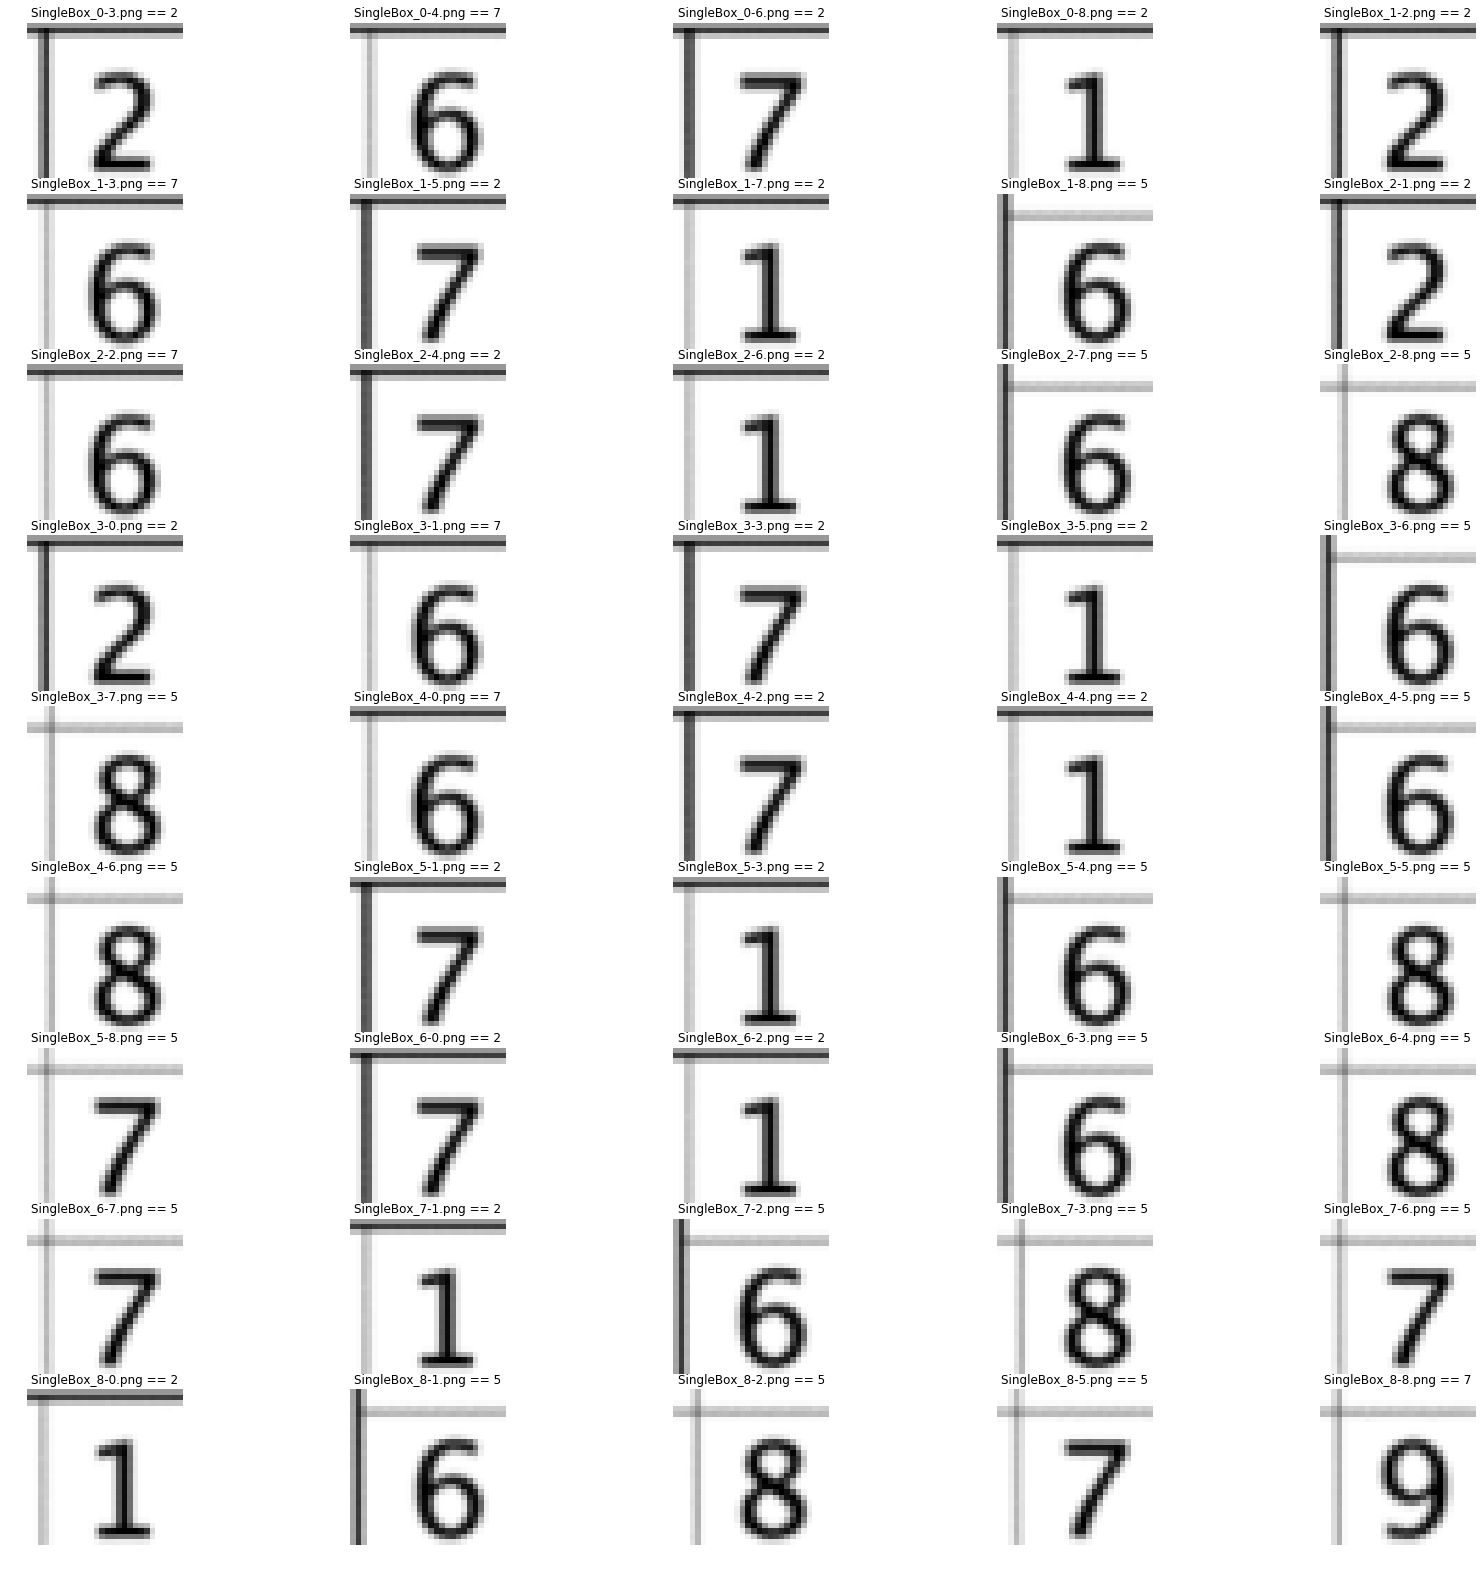

In [24]:
predict_and_print_nicely(new_recognizer)